# Readout Mitigation

These code examples are just some simple approaches to error mitigation one can follow. More examples can be found in:

* Qiskit tutorials: https://qiskit.org/documentation/experiments/tutorials/readout_mitigation.html
* Mitiq package : https://mitiq.readthedocs.io/en/stable/examples/examples.html

Let's create the most simple circuit we could think of.

In [1]:
from qiskit import QuantumCircuit

# |00>
qc = QuantumCircuit(2,2)
qc.measure([0, 1], [0, 1])

And we will replicate the noise model of one of IBM's available devices. For that remember you might need to first save your current account by invoking
```
from qiskit import IBMQ

IBMQ.save_account("<IBM experience token>")
```

In [2]:
from qiskit import IBMQ
from qiskit.providers.aer import AerSimulator

# IBMQ.save_account(TOKEN)
IBMQ.load_account() # Load account from disk
provider = IBMQ.get_provider(hub='ibm-q', group='open', project='main')
backend = provider.get_backend('ibmq_lima')

In [3]:
simulator = AerSimulator()
emulator = AerSimulator.from_backend(backend)

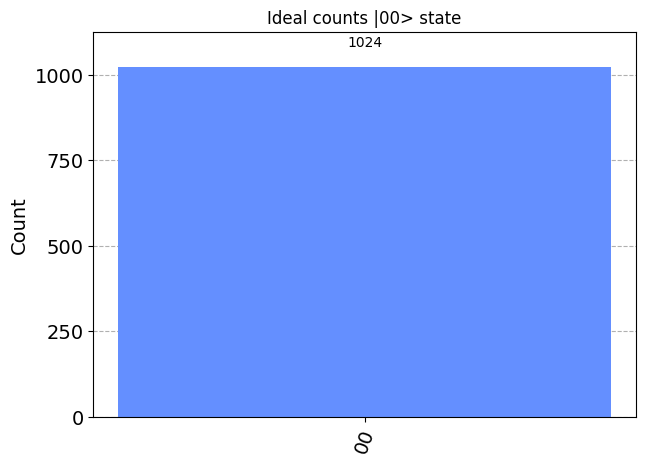

In [4]:
from qiskit.tools.visualization import plot_histogram

# Execute and get counts
result = simulator.run(qc).result()
counts = result.get_counts(0)
plot_histogram(counts, title='Ideal counts |00> state')

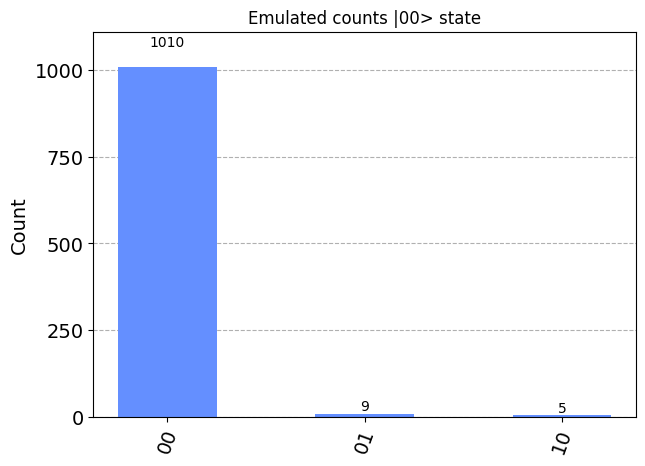

In [5]:
from qiskit import transpile

# Execute and get counts
result = emulator.run(qc).result()
counts = result.get_counts(0)
plot_histogram(counts, title='Emulated counts |00> state')

It is evident there is some noise introduced in our transpiled circuit even though it is quite simple. Let's try to mitigate it.

Qiskit already provides tools to create the circuits needed to get the calibration matrix.

In [10]:
from qiskit.visualization import plot_histogram
from qiskit_experiments.library import CorrelatedReadoutError

qubits = [0,1]
num_qubits = len(qubits)
exp = CorrelatedReadoutError(qubits)
for c in exp.circuits():
    print(c)

         ░ ┌─┐   
   q_0: ─░─┤M├───
         ░ └╥┘┌─┐
   q_1: ─░──╫─┤M├
         ░  ║ └╥┘
meas_0: ════╩══╬═
               ║ 
meas_1: ═══════╩═
                 
        ┌───┐ ░ ┌─┐   
   q_0: ┤ X ├─░─┤M├───
        └───┘ ░ └╥┘┌─┐
   q_1: ──────░──╫─┤M├
              ░  ║ └╥┘
meas_0: ═════════╩══╬═
                    ║ 
meas_1: ════════════╩═
                      
              ░ ┌─┐   
   q_0: ──────░─┤M├───
        ┌───┐ ░ └╥┘┌─┐
   q_1: ┤ X ├─░──╫─┤M├
        └───┘ ░  ║ └╥┘
meas_0: ═════════╩══╬═
                    ║ 
meas_1: ════════════╩═
                      
        ┌───┐ ░ ┌─┐   
   q_0: ┤ X ├─░─┤M├───
        ├───┤ ░ └╥┘┌─┐
   q_1: ┤ X ├─░──╫─┤M├
        └───┘ ░  ║ └╥┘
meas_0: ═════════╩══╬═
                    ║ 
meas_1: ════════════╩═
                      


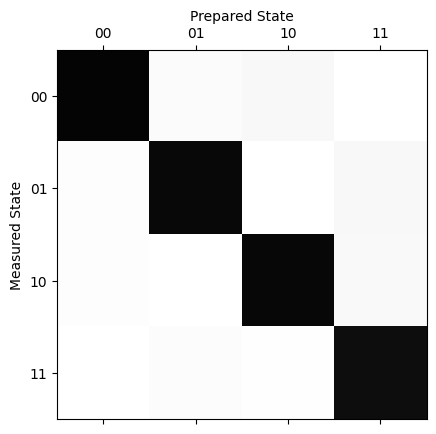

In [13]:
result = exp.run(emulator)
mitigator = result.analysis_results(0).value
result.figure(0)

In [34]:
unmitigated_probs = {label: count / 1024 for label, count in counts.items()}

mitigated_quasi_probs = mitigator.quasi_probabilities(counts)
mitigated_probs = (mitigated_quasi_probs.nearest_probability_distribution())

In [35]:
mitigated_probs

{0: 0.9999999999999998}

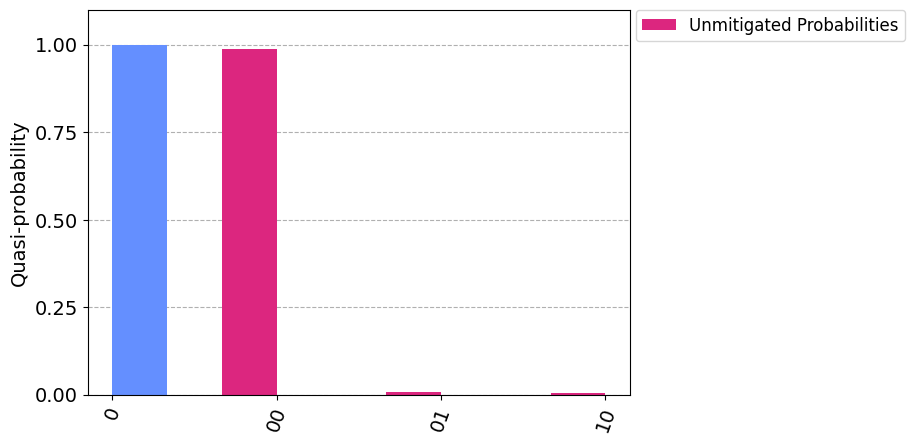

In [31]:
legend = ['Mitigated Probabilities', 'Unmitigated Probabilities']
plot_histogram([mitigated_probs, unmitigated_probs], legend=legend, sort="value_desc", bar_labels=False)